# COSE474-2024F: Deep Learning HW2

### 2022320017 Youjin Kim

# 7. Convolutional Neural Networks

- CNNs are computationally efficient because..
    - fewer parameters than fully-connected architectures
    - convolutions are easy to parallelize across GPU cores

## <i>7.1. From Fully Connected Layers to Convolutions

### 7.1.1. Invariance

CNNs systemize 'spatial invariance', exploiting it to learn useful representations with fewer parameters. 
1. Translation Invariance : all patches of an image will be treated in the same manner (regardless of location)
2. Locality Principle : earliest layers focus on **local** regions. Then, these are aggregated to make predictions at the whole image level. Only a small neighborhood of pixels will we used to compute the corresponding hidden representation.
3. deeper layers should capture **longer-range features** of the image

### 7.1.2. Constraining the MLP

$X$ : 2D image (input) <br>
$H$ : immediate hidden representations of $X$ (2D tensor)<br>
($X$ and $H$ have the same shape)<br>
$U$ : bias

If we use fourth-order weight tensors W, the total number of parameters required for a **single** layer in this parameterization is the following:<br>
1000x1000 image(1 megapizel) mapped to 1000x1000 hidden representation : requires $10^{12}$ parameters

1. Translation Invariance
- Implies that a shipt in $X$ should simply lead to a shift in $H$.That is, bias and weights X depend on pixel location. 
- total number of parameter : $4*10^6$
- e.g. Time-delay neural networks (TDNNs)

2. Locality
- outside some range $|a|>\Delta$ or $|b|>\Delta$, we should set weight=0
- reduces # of parameter : $4\Delta^2$ where $\Delta<10$
- convolutional layer : 
$$[H]_{i,j}=u+\sum_{a=-\Delta}^{\Delta}\sum_{b=-\Delta}^{\Delta} [V]_{a,b}[X]_{i+a,j+b}$$
- $V$ : convolution kernel/filter/weight

3. Deeper layers : by interleaving nonlinearities & convolutional layers repeatedly, we can represent larger and more complex aspects of an image





### 7.1.3. Convolutions

### 7.1.4. Channels

Adding Channels
- actual image : 1024x1024x3
- support multiple channels in both inputs(X) and hidden representations(H)
- putting together :
$$ [H]_{i,j,d}=\sum_{a=-\Delta}^{\Delta}\sum_{b=-\Delta}^{\Delta}\sum_{c} [V]_{a,b,c,d,}[X]_{i+a,j+b,c}
- d : output channels in H 
- V : kernel / filter of layer
- subsequent convolutional layer will take third-order tensor H as input.

## <i>7.2. Convolutions for Images

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.2.1. The Cross-Correlation Operation

In [2]:
# X : input tensor
# K : kernel tensor
# Y : output tensor
def corr2d(X,K): #@save
    """Compute 2D cross-correlation"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0]-h+1,X.shape[1]-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j] = (X[i:i+h, j:j+w]*K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 7.2.2. Convolutional Layers

In [4]:
# 2D convolutional layer
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size)) # initialize kernels randomly
        self.bias = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return corr2d(x, self.weight)+self.bias

### 7.2.3. Object Edge Detection in Images

In [6]:
X = torch.ones((6,8)) # construct a 6x8 image
X[:,2:6]=0 # middle 4 colums are black
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [7]:
# construct a height=1 width=2 kernel
K = torch.tensor([[1.0, -1.0]])

In [9]:
Y = corr2d(X,K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

we detect 1 for the edge from white to black and -1 for the edge from black to white

In [11]:
corr2d(X.t(), K)
# edge vanishes => means kernel K only detects vertical edges

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 7.2.4. Learning a Kernel

In [12]:
# Construct a two-dimensional convolution layer w/ 1 output channel and a kernel of shape (1,2).
# For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1,2), bias=False)

# The two-dimensional convolution layer uses four-dimensional input and 
# output in the format of (example, channel, height, width), where the batch size 
# (=# of examples in batch) and the number of channels are both 1
X = X.reshape((1,1,6,8))
Y = Y.reshape((1,1,6,7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2 # suqred error to compare Y w/ output of convolutional layer
    conv2d.zero_grad() # calculate the gradient to update the kernel
    l.sum().backward()
    # update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i+1)%2==0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 6.779
epoch 4, loss 1.147
epoch 6, loss 0.196
epoch 8, loss 0.035
epoch 10, loss 0.006


In [13]:
conv2d.weight.data.reshape((1,2))

tensor([[ 0.9900, -0.9830]])

The learned kernel tensor is remarkably close to the kernel tensor K we defined earlier.

### 7.2.5. Cross-Correlation and Convolution

since kernels are learned from data in deep learning, the outputs of convolutional layers remain unaffected no matter such layers perform either the strict convolution operations or the cross-correlation operations.

### 7.2.6. Feature Map and Receptive Field

- Feature Map : learned features in the spatial dimensionsto the subsequent layer
    - output of convolutional layer
- Receptive Field : all the elements that may affect the calculation of element x during forward propagation
    - receptive field may be larger than the actual size of input
    - neurophysiology : lower levels respond to edges and related shapes

## <i>7.3. Padding and Stride

When applying convolutional layers, we tend to lose pixels on the perimeter of our image.<br>
Padding and stride offers more control over the size of the output. 

In [14]:
import torch
from torch import nn

### 7.3.1. Padding

Add extra pixels of filter around the boundary of input image. (Thus, increasing the effective size of image)

If we add a totla of $p_h$ rows of padding and a total of $p_w$ columns of padding, the output shape will be 
$$(n_h - k_h + p_h + 1)*(n_w - k_w + p_w + 1)$$
The height and width of the output will increase py $p_h$ and $p_w$ respectively. 


In [21]:
# We define a helper function to calculate convolutions.
# It initializes the convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
    # (1,1) indicates that batch size and the # of channels are both 1
    X = X.reshape((1,1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions : examples and channels
    return Y.reshape(Y.shape[2:])

# 1 row and column is padded on eigther side, so a total 2 rows or column are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8,8))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

In [24]:
# We use a convolution kernel with height 5 and width 3. 
# The padding on either side of the height and width are 2 and 1, respecitvely. 
conv2d = nn.LazyConv2d(1, kernel_size=(5,3), padding=(2,1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 7.3.2. Stride

Stride can reduce the resolution of the output.<br>
When the stride for the height is $s_h$ and the stride for the width is $s_w$, the output shape is
$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor\times\lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor$$

In [25]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [27]:
conv2d = nn.LazyConv2d(1, kernel_size=(3,5), padding=(0,1), stride=(3,4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## <i>7.4. Multiple Input and Multiple Output Channels

### 7.4.1. Multiple Input Channels

In [28]:
# cross-correlation operations with multiple input channels
def corr2d_multi_in(X,K):
    # iterate through the 0th dimension(channel0 of K first, then add them
    return sum(d2l.corr2d(x,k) for x, k in zip(X,K))

In [37]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 7.4.2. Multiple Output Channels

In the most popular neural network architectures, we actually **increase** the channel dimension as we go deeper in the NN, typically downsampling to trade off spatial resolution for greater **channel depth**. 

The result on each output channel is calculated from the convolution kernel corresponding to that output chanel and takes input from all channels in the input tensor.

In [42]:
def corr2d_multi_in_out(X,K):
    # iterate through the 0th dimension of K, and each time, perform cross-correlation operationswith input X.
    # All of the Results are stacked together.
    return torch.stack([corr2d_multi_in(X,k) for k in K],0)

In [39]:
# construct trivial convolution kernel with 3 output channels 
# by concatentating kernel tensor for K with K+1 and K+2
K = torch.stack((K,K+1,K+2),0)
K.shape

torch.Size([3, 2, 2, 2])

In [45]:
corr2d_multi_in_out(X,K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 7.4.3. 1x1 Convolutional Layer

1x1 convolution loses the ability to regocnize patterns consisting the interactions among adjecent elements in the height and weight dimensions. The only computation occurs in the channel dimension. 

You could think of the 1x1 convolutional layer as consistuting a fully connected layer applied at every single pixel location to transform the $c_i$ corresponding input values to $c_o$ output values. 

In [46]:
# 1x1 convolution using a fully connected layer
def corr2d_multi_in_out_1x1(X,K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h*w))
    K = K.reshape((c_o,c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K,X)
    return Y.reshape((c_o, h, w))

In [48]:
X = torch.normal(0,1,(3,3,3))
K = torch.normal(0,1,(2,3,1,1))
Y1 = corr2d_multi_in_out_1x1(X,K)
Y2 = corr2d_multi_in_out_1x1(X,K)
assert float(torch.abs(Y1-Y2).sum())<1e-6

## <i>7.5. Pooling

Our ultimate task is learning a global representation of the image, so the units of our final layer should be sensitive to the entire input. The deeper we go in the network, the larger the receptive field (relative to the input) to which each hidden node is sensitive. Reducing spatial resolution accelerates this process, since the convolution kernels cover a larger effective area.

### 7.5.1. Maximum Pooling and Average Pooling

Unlike the cross-correlation computation of the inputs and kernels in the convolutional layer, the pooling layer **contains no parameters (there is no kernel)**. Instead, pooling operators are deterministic (calculating either max or avg value of elements in the pooling window).

- Average pooling : downsampling an image
- Max pooling : keep strong activation
    - we can still detect pattern even though there is translation.
    - confers some degree of invariance to output.

In [49]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0]-p_h+1, X.shape[1]-p_w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode=='max':
                Y[i,j] = X[i: i+p_h, j: j+p_w].max()
            elif mode=='avg':
                Y[i,j] = X[i: i+p_h, j: j+p_w].mean()
    return Y

In [50]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [51]:
pool2d(X,(2,2),'avg')

tensor([[2., 3.],
        [5., 6.]])

### 7.5.2. Padding and Stride

In [52]:
# first construct an input tensor X whose shape has 4 dimensions, where the number of examples(batch size) and number of channels are both 1
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [55]:
pool2d = nn.MaxPool2d(3)
# if we use a pooling window of shape (3,3), we get a stride shape of (3,3) by default.
pool2d(X)

tensor([[[[10.]]]])

In [56]:
# we can specify an arbitrary rectangular pooling window with arbttrary height and width
pool2d = nn.MaxPool2d((2,3), stride=(2,3), padding=(0,1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 7.5.3. Multiple Channels

When processing mult-channel input data, the pooling layer pools each input channel separately, rather than summing up over channels.
Number of output channels for the pooling layer is the same as the number of input channels

In [59]:
# concatentate X and X+1 on the channel dimension to construct an input with 2 channels
X = torch.cat((X,X+1),1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [60]:
pool2d = nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)
# the number of output channels is stil 2 after pooling

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## <i>7.6. Convolutional Neural Networks (LeNet)

**LeNet**: introduced by (and named for) Yann LeCun for the purpose of recognizing handwritten digits in images

### 7.6.1. LeNet

LeNet consists of 2 parts
1. A convolutional encoder consisting of 2 convolutional layers
    - each convolutional block : convolutional layer(5x5 kernel) + sigmoid activation + avg pooling(2x2, stride 2)
        - maps spatially-arranged inputs to a number fo 2D feature maps, increasing the number of channels
        - 1st convolutional layer : 6 output channel
        - 2nd convolutional layer : 16 output channel
        - each pooling : reduces dimensionality by a factor of 4 via spatial downsampling
    - ReLUs and max-pooling work better though..
2. A dense block consisting of 3 fully connected layers
    - in order to pass output from convolutional block to the dense block, we must flatten each example in the minibatch. 
    - we take 4D input (batchsize, # of channel, height, width) and transform it into 2D input expected by fully-connected layers
    - 3 fully connected lyaers with 120, 84, 10 outputs (10 = # of possible output classes)

In [67]:
def init_cnn(module): #@save
    """Initialize weights for CNNs."""
    if type(module)==nn.Linear or type(module)==nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier): #@save
    """The LeNet-5 model"""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes)
        )

In [68]:
# Let's see what happens inside the network, if we pass a single-channel 28x28 image.
@d2l.add_to_class(d2l.Classifier) #@save
def layer_summary(self,X_shape):
    X = torch.rand(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1,1,28,28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


### 7.6.2. Training

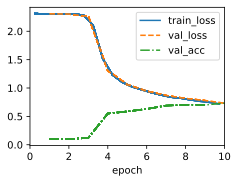

In [69]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]],init_cnn)
trainer.fit(model,data)

## <i>7.7. Discussion&Exercises

##### <u>7.7.1. Do you think that convolutional layers might also be applicable for text data? Which problems might you encounter with language?</u>

- Convolutional layers **can** be applicable for text data. They were successfully used in various NLP tasks such as text classification, machine translation, and sentiment analysis. 
    - In text, local patterns such as n-grams are important for some tasks, just as local pixel patterns are important in images. 
- However, there are several problems when dealing with language data.
    - Language data is inherently sequential and long. Therefore, CNN might fail to capture the meaning of the word if it depends on the earlier words. 
    - While input data size is usually fixed in images, text input data size varies. 

##### <u>7.7.2. What are the computational benefits of a stride larger than 1?</u>
- It helps reduce the feature dimension more quickly, by removing unnecessary computational burden.

##### <u>7.7.3. Try to visualize the output of each layer.</u>

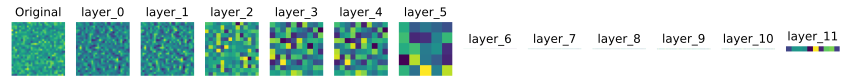

In [79]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Hook을 통해 레이어의 출력을 저장할 딕셔너리
activations = {}

# Forward hook 함수 정의 (출력을 activations 딕셔너리에 저장)
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# LeNet 모델 인스턴스 생성
model = LeNet()

# Hook을 모든 레이어에 등록
for idx, layer in enumerate(model.net):
    layer.register_forward_hook(get_activation(f'layer_{idx}'))

# 예시 입력 데이터 (배치 크기 1, 채널 1, 28x28 크기의 이미지)
example_data = torch.randn(1, 1, 28, 28)

# 모델에 데이터 통과 (forward)
output = model.net(example_data)

# 모든 레이어의 출력을 시각화하는 함수
def plot_all_feature_maps(activations, original):
    """모든 레이어의 출력을 시각화하는 함수"""
    
    num_layers = len(activations)  # 등록된 레이어의 개수
    fig, axes = plt.subplots(1, num_layers + 1, figsize=(15, 15))
    
    # 원본 이미지 시각화
    axes[0].imshow(original.squeeze())
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # 각 레이어의 출력 시각화
    for idx, (layer_name, activation) in enumerate(activations.items()):
        # 출력이 4차원일 때, 첫 번째 필터만 시각화
        if activation.ndim == 4:
            axes[idx + 1].imshow(activation[0, 0].cpu())
        else:
            axes[idx + 1].imshow(activation.cpu())
        axes[idx + 1].set_title(f'{layer_name}')
        axes[idx + 1].axis('off')
    
    plt.show()

# 원본 이미지와 모든 레이어의 출력 시각화
plot_all_feature_maps(activations, example_data)


# 8. Modern Convolutional Neural Networks

## <i>8.2. Networks Using Blocks (VGG)

Named after Visual Geometry Group (VGG) at Oxford University.

### 8.2.1. VGG Blocks

Basic building block of CNN is a sequence of ...
1. a convolutional layer with padding to maintain the resolution (3x3 kernel w/ padding 1)
2. a nonlinearity (e.g. ReLU)
3. a pooling layer (e.g. max-pooling) to reduce resolution (2x2 max-pooling w/ stride 2)

One problem : spacial resolution decreases rapidly <br>
-> hard limit of $log_2d$ convolutional layers on the network before all dimensions $d$ are used up.

- deep and narrow networks significantly outperform their shallow couterparts

In [80]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

### 8.2.2. VGG Network

VGG network can be partitioned into 2 parts :
1. consisting of convolutional & pooling layers
2. consisting of fully connected layers (identical to AlexNet)

Key difference : convolutional layers are gouped in nonlinear transforms that leave the dimensionality unchanged, followed by a resolution-reduction step.

In [81]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        # arch consists of a list of tuple containing 2 values : # of convolutional layers and # of output channels
        for (num_convs, out_channels) in arch: 
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes)
        )
        self.net.apply(d2l.init_cnn)

In [82]:
# original VGG network has 5 convolutional blocks
# (# of convolutional layer, # of output channels)
# since this network uses 8 convolutional layers and 3 fully-connected layers, it is often called VGG-11
VGG(arch=((1,64),(1,128),(2,256),(2,512),(2,512))).layer_summary((1,1,224,224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 8.2.3. Training

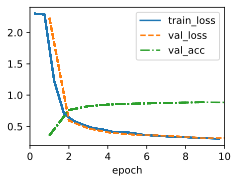

In [90]:

# MPS 디바이스 사용 여부 확인
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# VGG 모델 설정 (모델을 MPS로 이동)
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01).to(device)

# Trainer 설정
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)

# DataLoader 설정
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))

# 모델 초기화 (초기 데이터를 float32로 변환하고 MPS로 이동)
X = next(iter(data.get_dataloader(True)))[0].to(device).float()
model.apply_init([X], d2l.init_cnn)

# 모델 학습 함수 수정
def prepare_batch_mps(batch):
    # 모든 배치를 MPS로 이동
    X, y = batch
    return X.to(device).float(), y.to(device)

# Trainer 클래스의 prepare_batch 함수 덮어쓰기
trainer.prepare_batch = prepare_batch_mps

# 모델 학습
trainer.fit(model, data)


## <i> 8.6. Residual Networks(ResNet) and ResNeXt

In [91]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 8.6.1. Function Classes

For deep neural networks, if we can train the newly-added layer into an identity function $f(x)=x$, the new model will be as effective as the original model. As the new model may get a better solution to fit the training dataset, the added layer might make it easier to reduce training errors.

**Residual Network(ResNet)**
- every additional layer should more easily contain the identity function as one of is elements.
- led to 'residual block'


### 8.6.2. Residual Blocks

In order to get the input to the activation function, instead of learning $f(x)$, we learn <i>residual mapping</i> $g(x) = f(x)-x$. If $f(x)=x$ is the desired underlying mapping, the residual mapping amounts to $g(x)=0$, which is easier to learn : we only need to push the weights and biases of the upper layer to zero. 

Resnet has VGG's full 3x3 convolutional layer design. The residual block has 2 3x3 convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and ReLU. Then, we skip these two convolution operators and add teh input directly before the final ReLU. 

This kind of design requires that the ouput of the two convolutional layers has to be of the same shape as the input. 

In [98]:
class Residual(nn.Module): #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            # we adjust channels and resolutions by means of a 1x1 consolution before adding.
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        else:
            # we add the input to the output before applying ReLU
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [99]:
# input shape == output shape인 경우 (1x1 convolution not needed)
blk = Residual(3)
X = torch.randn(4,3,6,6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [100]:
# halve the output height and width while increasing # of output channels (1x1 convolution sued)
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### 8.6.3. ResNet Model

In [102]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

In [103]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk=[]
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [104]:
# add all modules to ResNet (2 residual blocks used for each module)
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}',self.block(*b, first_block=(i==0)))
    self.net.add_module('last',nn.Sequential(
        nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
        nn.LazyLinear(num_classes)
    ))
    self.net.apply(d2l.init_cnn)

In [105]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2,64), (2,128), (2,256), (2,512)),
                         lr, num_classes)
        
ResNet18().layer_summary((1,1,96,96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


### 8.6.4. Training

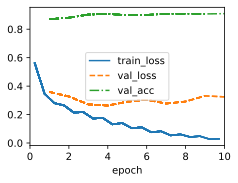

In [110]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96,96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]],d2l.init_cnn)
trainer.fit(model, data)

## <i>8.7. Discussion&Exercise

##### <u>8.7.1. Discuss the pros and cons of VGG, and ResNet.</u>

**1.VGG**
- Pros : simple architecture (easy to understand and implement), good feature extraction
- Cons : large model size (computationally expensive and slow training), no skip connections, susceptible to overfitting on small datasets w/o proper regularization

**2. ResNet**
- Pros : very deep architecture (vanishing gradient problem overcome), skip connections, high performance
- Cons : complex to understand and implement, requires significant computational power and memory, still long time to train(converge)